# HiCCUPS anchors VS conserved boundaries

In [1]:
import src
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns

from pybedtools.bedtool import BedTool
from pybedtools import cleanup
cleanup()

figure_path = src.figures_path / "hiccups"
os.makedirs(figure_path, exist_ok=True)

In [2]:
hiccups = pd.read_csv(src.processed_data_path / "GSE63525_HiCCUPS_loops.tsv", sep="\t")

source_anchors = hiccups[['sourceChrom', 'sourceStart', 'sourceEnd']].copy()
source_anchors.columns = src.coords
target_anchors = hiccups[['targetChrom', 'targetStart', 'targetEnd']].copy()
target_anchors.columns = src.coords

hiccups_anchors = pd.concat((source_anchors, target_anchors), axis=0, ignore_index=True)
hiccups_anchors = hiccups_anchors.drop_duplicates().sort_values(src.coords)
print("# hiccups anchors:", hiccups_anchors.shape[0])
hiccups.head()

# hiccups anchors: 16123


,sourceChrom,sourceStart,sourceEnd,targetChrom,targetStart,targetEnd,observed,expected_donut,fdr_donut,enrichment_score,loop_id,sourceId,targetId
0,chr1,1050000,1060000,chr1,1180000,1190000,241,118.8020,9.583457e-17,2.028585,0,0,1
1,chr1,1585000,1590000,chr1,1645000,1650000,80,27.6775,1.413254e-09,2.890434,1,2,3
2,chr1,1710000,1715000,chr1,1835000,1840000,154,53.7355,1.298644e-18,2.865889,2,4,5
3,chr1,2120000,2130000,chr1,2310000,2320000,506,143.4070,3.235315e-100,3.528419,3,6,8
4,chr1,2130000,2135000,chr1,2515000,2520000,52,20.7272,1.554971e-03,2.508781,4,7,12


In [3]:
window = 25000
consensus_boundaries = pd.read_csv(src.interim_data_path / "consensus_boundaries" / "consensus_boundaries_w{}.tsv".format(window), sep = "\t")
consensus_boundaries['consensus_boundary_uid'] = np.arange(consensus_boundaries.shape[0], dtype=int)
consensus_boundaries.head()

,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,MK,Mac0,Mon,nB,nCD4,nCD8,length,covered_genome,consensus_boundary_uid
0,chr1,1612500,1612500,Mon_0000_start,Mon,1,1,0,0,0,1,0,0,0,1,3.223947e-10,0
1,chr1,1646875,1646875,nB_0000_start,nB,1,1,0,0,0,0,1,0,0,1,3.223947e-10,1
2,chr1,1842500,1847500,"nB_0000_end,Ery_0000_start,Mon_0000_end","Ery,nB,Mon",3,3,1,0,0,1,1,0,0,5001,1.612296e-06,2
3,chr1,2112500,2112500,"nB_0001_start,Mac0_0000_start","nB,Mac0",2,2,0,0,1,0,1,0,0,1,3.223947e-10,3
4,chr1,2342500,2350000,"nB_0001_end,Mac0_0000_end,Ery_0000_end,nB_0002...","nCD8,Ery,nB,Mac0",4,5,1,0,1,0,2,0,1,7501,2.418282e-06,4


### We normalize the length of boundaries
We take the center and extend $\pm 25kb$

In [4]:
half_window = 25000
centers = ((consensus_boundaries.start + consensus_boundaries.end) / 2).astype(int)
consensus_boundaries_fixed = consensus_boundaries.copy()
consensus_boundaries_fixed['start'] = centers
consensus_boundaries_fixed['end'] = centers
consensus_boundaries_fixed = BedTool.from_dataframe(consensus_boundaries_fixed)\
                                    .slop(b=half_window, genome='hg19')\
                                    .to_dataframe(names=consensus_boundaries.columns)
consensus_boundaries_fixed.head()

,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,MK,Mac0,Mon,nB,nCD4,nCD8,length,covered_genome,consensus_boundary_uid
0,chr1,1587500,1637500,Mon_0000_start,Mon,1,1,0,0,0,1,0,0,0,1,3.223947e-10,0
1,chr1,1621875,1671875,nB_0000_start,nB,1,1,0,0,0,0,1,0,0,1,3.223947e-10,1
2,chr1,1820000,1870000,"nB_0000_end,Ery_0000_start,Mon_0000_end","Ery,nB,Mon",3,3,1,0,0,1,1,0,0,5001,1.612296e-06,2
3,chr1,2087500,2137500,"nB_0001_start,Mac0_0000_start","nB,Mac0",2,2,0,0,1,0,1,0,0,1,3.223947e-10,3
4,chr1,2321250,2371250,"nB_0001_end,Mac0_0000_end,Ery_0000_end,nB_0002...","nCD8,Ery,nB,Mac0",4,5,1,0,1,0,2,0,1,7501,2.418282e-06,4


In [5]:
consensus_boundaries_fixed_hiccups = BedTool.from_dataframe(consensus_boundaries_fixed)\
                                            .map(BedTool.from_dataframe(hiccups_anchors), c=1, o='count')\
                                            .to_dataframe(names=consensus_boundaries_fixed.columns.tolist() + ['n_hiccup_anchors'])
consensus_boundaries_fixed_hiccups['has_hiccup'] = consensus_boundaries_fixed_hiccups.n_hiccup_anchors.map(lambda x: "Intersects HiCCUP" if x>0 else "Does not intersect HiCCUP")
consensus_boundaries_fixed_hiccups.head()

,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,MK,Mac0,Mon,nB,nCD4,nCD8,length,covered_genome,consensus_boundary_uid,n_hiccup_anchors,has_hiccup
0,chr1,1587500,1637500,Mon_0000_start,Mon,1,1,0,0,0,1,0,0,0,1,3.223947e-10,0,1,Intersects HiCCUP
1,chr1,1621875,1671875,nB_0000_start,nB,1,1,0,0,0,0,1,0,0,1,3.223947e-10,1,1,Intersects HiCCUP
2,chr1,1820000,1870000,"nB_0000_end,Ery_0000_start,Mon_0000_end","Ery,nB,Mon",3,3,1,0,0,1,1,0,0,5001,1.612296e-06,2,1,Intersects HiCCUP
3,chr1,2087500,2137500,"nB_0001_start,Mac0_0000_start","nB,Mac0",2,2,0,0,1,0,1,0,0,1,3.223947e-10,3,2,Intersects HiCCUP
4,chr1,2321250,2371250,"nB_0001_end,Mac0_0000_end,Ery_0000_end,nB_0002...","nCD8,Ery,nB,Mac0",4,5,1,0,1,0,2,0,1,7501,2.418282e-06,4,1,Intersects HiCCUP


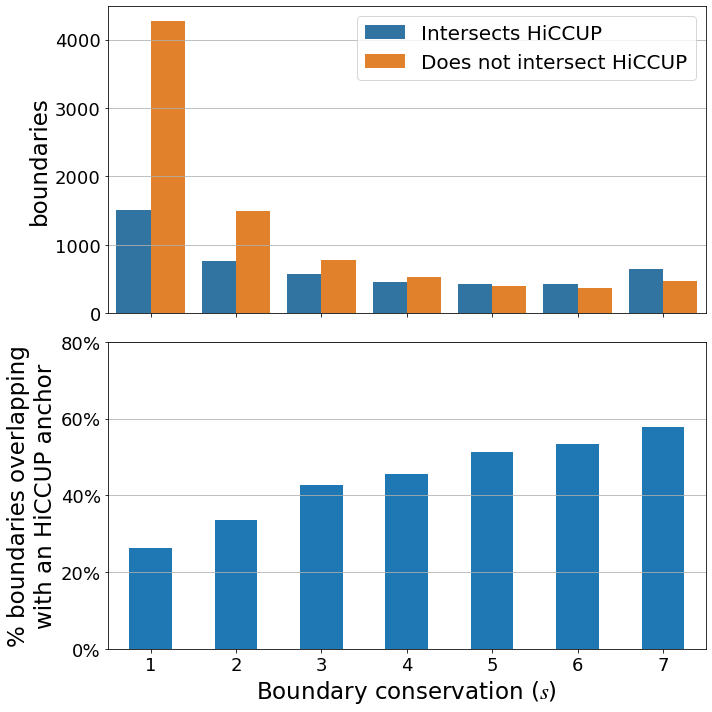

In [10]:
fig, axes = plt.subplots(2,1, sharex=True, figsize=(10, 10))
sns.countplot(data=consensus_boundaries_fixed_hiccups, x='n_cell_types', hue='has_hiccup', ax=axes[0])
axes[0].legend()
axes[0].grid(axis='y')
axes[0].set_ylabel("boundaries", fontsize=23)
axes[0].legend(fontsize=20)
x = consensus_boundaries_fixed_hiccups.groupby(['n_cell_types', 'has_hiccup']).size().unstack()
x = x.div(x.sum(1), axis=0)
x['Intersects HiCCUP'].plot.bar(ax=axes[1])
plt.ylim(0, 0.8)
yticks, _ = plt.yticks()
plt.yticks(yticks, ["{:.0f}%".format(yi*100) for yi in yticks], rotation=0)
plt.xticks(rotation=0)
plt.xlabel("Boundary conservation ($s$)", fontsize=23)
plt.ylabel("% boundaries overlapping\nwith an HiCCUP anchor", fontsize=23)
fig.savefig(figure_path / "bounds_vs_hiccups_intersects.pdf", bbox_inches='tight', transparent=True)
plt.grid(axis='y')